In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import drms
from astropy.coordinates import SkyCoord
import astropy.units as u 
import sunpy.coordinates
import astropy.io.fits as fits
import matplotlib.patches as ptc

In [4]:
# Take in: t_rec
# Plot: full solar disk + ARs + network
time = "2011.02.14_15:00:00/10m"
c = drms.Client()


In [47]:
# keys, segments = c.query('hmi.sharp_720s[][{}]'.format(time), key='T_REC, URL,HARPNUM, LON_FWT, LAT_FWT', seg="magnetogram")
# print(keys)

seg_urls = c.query('hmi.sharp_720s[][{}]'.format(time), seg="magnetogram")
print(seg_urls.loc[1, "magnetogram"])

/SUM90/D1043168341/S00000/magnetogram.fits


In [29]:
def calculate_distance_graph(series):
    # get all indices that match, get skycoord objects
    skycoord_list = []
    count=series.shape[0]
    # Error because this line only returns 1 row.
    for ind in range(count):
        row = series.loc[series.index[ind]]
        hgs = SkyCoord(row["LON_FWT"]*u.deg,
                              row["LAT_FWT"]*u.deg,
                              obstime = row["T_REC"],
                              frame = "heliographic_stonyhurst")
        hc = hgs.transform_to("heliocentric")

        skycoord_list.append(hc)
    dist_graph = dict()
    # Initialize dict
    for i in range(count):
        dist_graph[i] = np.zeros(count)

    for i in range(count):
        for j in range(i, series.shape[0]):
            if i==j:
                dist_graph[i][j] = float('inf')
                dist_graph[j][i] = float('inf')
            else:
                # Calculate the Great-Circle distance
                dist = skycoord_list[i].separation(skycoord_list[j])
                dist_graph[i][j] = dist.degree
                dist_graph[j][i] = dist.degree

    # print(skycoord_list)
    return dist_graph, skycoord_list


In [30]:
keys_hmi, segments = c.query('hmi.M_720s[{}]'.format(time), key=drms.const.all, seg='magnetogram')
url_hmi = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_full_image = fits.getdata(url_hmi)                   # download the image data
header = dict(keys_hmi.iloc[0])
# Add a DATE-OBS keyword which seems to be required by sunpy.map.Map.
header['DATE-OBS'] = keys_hmi.DATE__OBS[0]

# Add HGLN_OBS keyword to avoid a warning in sunpy.map.Map.
header['HGLN_OBS'] = 0.0

In [31]:
keys_ccd, segments = c.query('hmi.sharp_720s[][{}]'.format(time), key=drms.const.all, seg='magnetogram')


In [32]:
dist_graph, skycoord_list = calculate_distance_graph(keys_ccd)
print(dist_graph)

{0: array([        inf, 40.75748011, 49.08184434, 31.57644293, 43.05219335,
       49.62997934, 81.0442801 , 72.33842021, 70.76647784, 91.04243196,
       44.64859397]), 1: array([ 40.75748011,          inf,  11.97942052,  53.42913945,
        52.34161908,  29.83628962,  71.0055993 ,  84.80570184,
        88.47551214, 101.32316369,  48.11719161]), 2: array([49.08184434, 11.97942052,         inf, 54.18936703, 49.2949159 ,
       21.53151821, 60.87373645, 79.03912418, 83.98341821, 93.69433241,
       43.9659654 ]), 3: array([31.57644293, 53.42913945, 54.18936703,         inf, 14.84596596,
       40.0293043 , 53.6242447 , 40.90344109, 40.3036675 , 59.7970841 ,
       19.84215952]), 4: array([43.05219335, 52.34161908, 49.2949159 , 14.84596596,         inf,
       30.59806093, 39.20752131, 33.73478273, 36.23501315, 52.26920888,
        6.35724199]), 5: array([49.62997934, 29.83628962, 21.53151821, 40.0293043 , 30.59806093,
               inf, 41.45773946, 57.64079102, 62.99506719, 72.289404

In [ ]:
def plot_dist_graph(dist_graph, x_middle, y_middle):
    
    for k in dist_graph.keys():
        # For each key ind > k_index, draw a line between x_middle[key], y_middle[key] and x_middle[ind], y_middle[ind]
        for i in range(k, len(dist_graph[k])):
            plt.plot([x_middle[k],x_middle[i]], [y_middle[k], y_middle[i]], linewidth=4, color='steelblue')


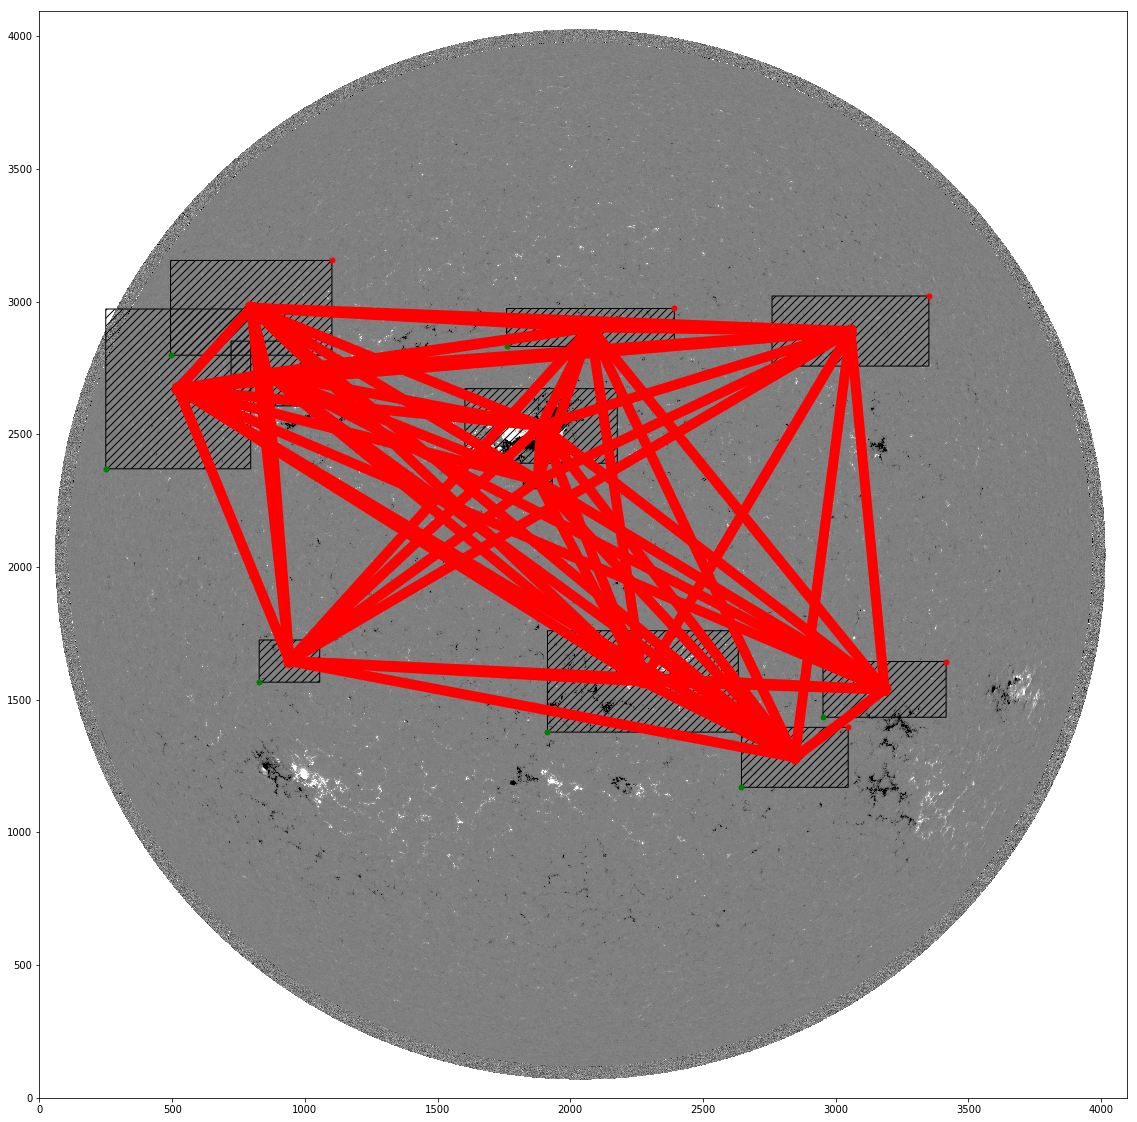

In [39]:
hmimag = plt.get_cmap('gray')
fig, ax = plt.subplots(1,1)

fig.set_size_inches(20,20)
x_middle = []
y_middle = []

for i, url_seg in enumerate(segments.loc[:,"magnetogram"]):
    url_ccd = 'http://jsoc.stanford.edu' + url_seg   # add the jsoc.stanford.edu suffix to the segment name
    photosphere_image = fits.open(url_ccd)                           # download the data
    XDIM_CCD = photosphere_image[1].data.shape[1]
    YDIM_CCD = photosphere_image[1].data.shape[0]
    
    if (keys_ccd.CROTA2[i] > 5.0):
#         print("The HMI camera rotation angle is",keys_ccd.CROTA2[i],". Rotating HMI images.")
        photosphere_full_image = np.rot90(photosphere_full_image,2)
        photosphere_image[1].data = np.rot90(photosphere_image[1].data,2)

    
    y1 = (2048. + keys_ccd.CRPIX2[i] - YDIM_CCD)  
    y2 = (2048. + keys_ccd.CRPIX2[i])
    x1 = (2048. + keys_ccd.CRPIX1[i] - XDIM_CCD)
    x2 = (2048. + keys_ccd.CRPIX1[i])


    # draw a box using matplotlib.patches.Rectangle
    ax.add_patch(ptc.Rectangle((x1, y1), XDIM_CCD, YDIM_CCD, hatch='///', fill=False, snap=False))
    
    # plot a green dot at the lower left-hand corner
    plt.plot(x1, y1, 'g.', markersize=10.0)

    # plot a red dot at the upper right-hand corner
    plt.plot(x2, y2, 'r.', markersize=10.0)

    plt.plot((x1+x2)/2, (y1+y2)/2, 'b.',markersize=10)

    x_middle.append((x1+x2)/2)
    y_middle.append((y1+y2)/2)
    
plot_dist_graph(dist_graph, x_middle, y_middle)
plt.imshow(photosphere_full_image,cmap=hmimag,origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])


In [28]:
print(keys_ccd.LON_FWT)

0     36.320671
1     38.758030
2     28.806580
3      2.694037
4     -6.222026
5      6.878287
6    -36.926369
7    -39.875847
8    -40.521225
9    -59.132347
10    -5.086699
Name: LON_FWT, dtype: float64


The HMI camera rotation angle is 180.082581 . Rotating HMI images.


In [37]:
print(keys_ccd.CRPIX2)

0    1012.585205
Name: CRPIX2, dtype: float64
